In [1]:
#importing all libraries that are required
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import sklearn as sk
import math
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter("ignore")

In [2]:
#reading csv data as dataframe
df = pd.read_csv('AER_credit_card_data.csv')

In [3]:
# droping features that are not requied
df.drop([ 'share', 'expenditure', 'dependents', 'majorcards', 'active'],axis=1,inplace=True)

#['card', 'reports', 'age', 'income', 'owner', 'selfemp', 'months']

# encoding categorical features to integers (integer encoding) 
df['card'] = df['card'].astype("category").cat.codes
df['owner']=df['owner'].astype("category").cat.codes
df['selfemp']=df['selfemp'].astype("category").cat.codes

# creating dictionary to get type of feature cat=categorical,num=numbercial
get_type = {'card':'cat', 'reports':'num', 'age':'num', 'income':'num', 'owner':'cat', 'selfemp':'cat', 'months':'num'}

#dictionary of list to store answer
ansers_knn= {'card':[], 'reports':[], 'age':[], 'income':[], 'owner':[], 'selfemp':[], 'months':[]}
ansers_wknn= {'card':[], 'reports':[], 'age':[], 'income':[], 'owner':[], 'selfemp':[], 'months':[]}
ansers_all= {'card':[], 'reports':[], 'age':[], 'income':[], 'owner':[], 'selfemp':[], 'months':[]}

df.head()


,card,reports,age,income,owner,selfemp,months
0,1,0,37.66667,4.5200,1,0,54
1,1,0,33.25000,2.4200,0,0,34
2,1,0,33.66667,4.5000,1,0,58
3,1,0,30.50000,2.5400,0,0,25
4,1,0,32.16667,9.7867,1,0,64


In [4]:
class KNN:
    
    def __init__(self,x_train,y_train,data_type,col_list,weights=False,dist='euc',K=1):
        # x_train = input features training dataset
        # y_train = output labels of training dataset
        # data_type - ['num','cat'] what is datatype of output label
        # weights = weights=True for weighted KNN
        # dist - ['euc','ham','chi'] which distance measure to use
        # K - value of K in KNN
        
        self.x_train = x_train
        self.y_train = y_train
        self.dist = dist
        self.K = K
        self.data_type =data_type
        self.weights = weights
        self.col_list =col_list
            
        if dist=='euc':
            self.dist = self.euclidian_dist
        elif dist=='chi':
            self.dist = self.chi_square_dist
        else:
            self.dist = self.hamming_dist
            
    def euclidian_dist(self,point1,point2):
        dist=0
        for m in range(len(point1)):
            dist+=  (point1[m]-point2[m])**2
        return math.sqrt(dist)

    def chi_square_dist(self,point1,point2):
        dist=0
        for m in range(len(point1)):
            if get_type[self.col_list[m]] == 'num':
                dist+= ((point1[m]-point2[m])**2) /(0.1+point1[m]+point2[m]) 
            else:
                dist+= 2*abs(point1[m]-point2[m]) 
        return dist/2.0
    
    def hamming_dist(self,point1,point2):
        dist=0
        for m in range(len(point1)):
            dist+=  abs(point1[m]-point2[m])
        
        return dist
    
    #defining weight
    def W(self,X):
        w= 1 if X==0.0 else 1/(X**2)
        return w
    
    #prectict label for given point p
    def predict(self,point):
        
        distances = []
        #iterate through all training data
        for p,i in zip(self.x_train,range(len(self.x_train))):
            # get distance according to selected distance measure
            d=self.dist(point,p)
            # append distance with label in list of tuples [(dist,label), ...] 
            distances.append((d,self.y_train[i]))
        
        #sort according to distance
        distances.sort()
        
        # if label to be predicted is numerical
        if self.data_type == 'num':
            dist_sum=0.0
            sum_w = 0.0
            # if we need to find weighted KNN 
            if self.weights ==True:
                for i in range(len(self.x_train)):
                    wi = self.W(distances[i][0])
                    dist_sum+=wi*distances[i][1]
                    sum_w += wi
                sum_w = round(sum_w,2)
                return round(dist_sum/sum_w,2) if sum_w > 0.01 else dist_sum 
            
            # if it is normal KNN 
            else:
                for i in range(self.K):
                    dist_sum+=distances[i][1]
                return round(dist_sum/self.K,2)
            
        # else if label to be predicted is categorical
        else:
           #if we need to find weighted KNN 
            if self.weights ==True:
                lbs = {}
                # add all weights for label
                for i in range(len(self.x_train)):
                    if distances[i][1] in lbs.keys():
                        lbs[distances[i][1]]+=self.W(distances[i][0])
                    else:
                        lbs[distances[i][1]]=self.W(distances[i][0])
                max_weight =0
                label_ans=0
                # find the label with max total weight
                for label in lbs.keys():
                    if max_weight < lbs[label]:
                        max_weight = lbs[label]
                        label_ans = label
                return label_ans
            
            # if it is normal KNN   
            else:
                lbs =[]
                # find the MODE(most occuring) of labels in nearest K neighbours
                for i in range(self.K):
                    lbs.append(distances[i][1])

                return stats.mode(lbs).mode[0]
    

In [5]:
# defining accuracy measure
def calculate_accuracy(y_true, y_pred, data_type):
    if data_type == 'num':
        return r2_score(y_true, y_pred)
    else:
        return accuracy_score(y_true, y_pred)

N = len(df) #total number of samples

removal_percent_list = [0.05,0.10,0.20]
col_name_list = ['card', 'reports', 'age', 'income', 'owner', 'selfemp', 'months']


# removal_percent = 0.05
# col_name = 'income'
for col_name in col_name_list:
    feature_list = col_name_list.copy()
    feature_list.remove(col_name)
    for removal_percent in removal_percent_list:
        
        # calculate  num = removal_percent * total_rows
        num = int(np.rint(removal_percent * N))

        # genrate num ramdom interger in range [0,N)
        row_nums = random.sample(range(num),num)
        
        # make copy of dataframe so that maipulation are made on copy
        df_copy = df.copy()
        
        # initialize standard scaler
        scaler = MinMaxScaler()
        
        # column list that contains all col name except curr col : used for scaling
        feature_cols  = [x for x in col_name_list if not col_name==x]
        
        # scale all columns except label column
        df_copy[feature_cols] = scaler.fit_transform(df_copy[feature_cols])
        df_copy[col_name] = df[col_name].copy()
        
        
        # replace actual values with NaN in the randomly genrated rows and store actual values in target_values list to
        # calculate accuracy later
        target_values = []
        for i in row_nums:
            target_values.append(df_copy[col_name][i])
            df_copy[col_name][i] = np.NaN
            
        # test data will contain rows without missing values
        test_data = df_copy[pd.isnull(df_copy[col_name])].copy()
        
        # test data will contain rows who have missing values
        train_data = df_copy[pd.isnull(df_copy[col_name])==False].copy()
        
        
        
        # split data into input feature and target values
        X_train = train_data.drop(col_name,axis=1).values
        Y_train = train_data[col_name].values
        
        # split data into input feature and target values
        X_test = test_data.drop(col_name,axis=1).values
        Y_test = np.ravel(np.array(target_values))
        
        for val_of_k in [1,7,'weighted']:
            
            for dist_mes in ['euc','ham','chi']:
                
                if val_of_k == 'weighted':
                    
                    val_K=5
                    weight = [1,2,3,4,5,6]
                    knn = KNN(X_train,Y_train,get_type[col_name],feature_list,dist=dist_mes,K=val_K,weights=weight)
                    Y_pred=[]
                    error =0
                    for i in range(len(X_test)):
                        y=knn.predict(X_test[i])
                        Y_pred.append(y)
                        error+=abs(y-Y_test[i])
                    error = calculate_accuracy(Y_test,np.array(Y_pred),get_type[col_name])
                    print("Column Name : ",col_name,"Removal % :",removal_percent*100,"Weighted KNN :",weight,"Distance Measure : ",dist_mes,"Error : ",error)
                    ansers_wknn[col_name].append(error)
                    ansers_all[col_name].append(error)
                else:
                    
                    knn = KNN(X_train,Y_train,get_type[col_name],feature_list,dist=dist_mes,K=val_of_k)
                    Y_pred=[]
                    error =0
                    for i in range(len(X_test)):
                        y=knn.predict(X_test[i])
                        Y_pred.append(y)
                        error+=abs(y-Y_test[i])
                    error = calculate_accuracy(Y_test,np.array(Y_pred),get_type[col_name])
                    print("Column Name : ",col_name,"Removal % :",removal_percent*100,"K : ",val_of_k,"Distance Measure : ",dist_mes,"Error : ",error)
                    ansers_knn[col_name].append(error)
                    ansers_all[col_name].append(error)
            
            
            
            


Column Name :  card Removal % : 5.0 K :  1 Distance Measure :  euc Error :  0.6818181818181818
Column Name :  card Removal % : 5.0 K :  1 Distance Measure :  ham Error :  0.6666666666666666
Column Name :  card Removal % : 5.0 K :  1 Distance Measure :  chi Error :  0.696969696969697
Column Name :  card Removal % : 5.0 K :  7 Distance Measure :  euc Error :  0.696969696969697
Column Name :  card Removal % : 5.0 K :  7 Distance Measure :  ham Error :  0.7121212121212122
Column Name :  card Removal % : 5.0 K :  7 Distance Measure :  chi Error :  0.7121212121212122
Column Name :  card Removal % : 5.0 Weighted KNN : [1, 2, 3, 4, 5, 6] Distance Measure :  euc Error :  0.7121212121212122
Column Name :  card Removal % : 5.0 Weighted KNN : [1, 2, 3, 4, 5, 6] Distance Measure :  ham Error :  0.7121212121212122
Column Name :  card Removal % : 5.0 Weighted KNN : [1, 2, 3, 4, 5, 6] Distance Measure :  chi Error :  0.696969696969697
Column Name :  card Removal % : 10.0 K :  1 Distance Measure :  euc

Column Name :  age Removal % : 20.0 Weighted KNN : [1, 2, 3, 4, 5, 6] Distance Measure :  euc Error :  -0.2920273924793506
Column Name :  age Removal % : 20.0 Weighted KNN : [1, 2, 3, 4, 5, 6] Distance Measure :  ham Error :  -0.2835699865087846
Column Name :  age Removal % : 20.0 Weighted KNN : [1, 2, 3, 4, 5, 6] Distance Measure :  chi Error :  -0.24821846495596223
Column Name :  income Removal % : 5.0 K :  1 Distance Measure :  euc Error :  -1.2759287230780774
Column Name :  income Removal % : 5.0 K :  1 Distance Measure :  ham Error :  -1.3380624564793235
Column Name :  income Removal % : 5.0 K :  1 Distance Measure :  chi Error :  -1.7660737418392793
Column Name :  income Removal % : 5.0 K :  7 Distance Measure :  euc Error :  -0.2323294605645585
Column Name :  income Removal % : 5.0 K :  7 Distance Measure :  ham Error :  -0.21752881616877784
Column Name :  income Removal % : 5.0 K :  7 Distance Measure :  chi Error :  -0.19008552128427714
Column Name :  income Removal % : 5.0 We

Column Name :  selfemp Removal % : 20.0 K :  1 Distance Measure :  ham Error :  0.8825757575757576
Column Name :  selfemp Removal % : 20.0 K :  1 Distance Measure :  chi Error :  0.8636363636363636
Column Name :  selfemp Removal % : 20.0 K :  7 Distance Measure :  euc Error :  0.9393939393939394
Column Name :  selfemp Removal % : 20.0 K :  7 Distance Measure :  ham Error :  0.9393939393939394
Column Name :  selfemp Removal % : 20.0 K :  7 Distance Measure :  chi Error :  0.9393939393939394
Column Name :  selfemp Removal % : 20.0 Weighted KNN : [1, 2, 3, 4, 5, 6] Distance Measure :  euc Error :  0.9393939393939394
Column Name :  selfemp Removal % : 20.0 Weighted KNN : [1, 2, 3, 4, 5, 6] Distance Measure :  ham Error :  0.9356060606060606
Column Name :  selfemp Removal % : 20.0 Weighted KNN : [1, 2, 3, 4, 5, 6] Distance Measure :  chi Error :  0.9318181818181818
Column Name :  months Removal % : 5.0 K :  1 Distance Measure :  euc Error :  -1.1499990119213286
Column Name :  months Removal

In [6]:
# l1 = ['Euclidian','Hamming','Manhattab']*6
# l2 = [['K=1']*3,['K=5']*3]*3
# l3 = [['5% Missing']*6,['10% Missing']*6,['20% Missing']*6]
# l2=list(np.ravel(np.array(l2)))
# l3=list(np.ravel(np.array(l3)))
# pd.DataFrame(ansers_knn,index=[l3,l2,l1])

In [7]:
# l1 = ['Euclidian','Hamming','Chi Square']*3
# l2 = ['K=5']*9
# l3 = [['5% Missing']*3,['10% Missing']*3,['20% Missing']*3]
# l3=list(np.ravel(np.array(l3)))
# pd.DataFrame(ansers_wknn,index=[l3,l2,l1])

In [8]:

l1 = ['Euclidian','Hamming','Chi Square']*9
l2 = [['K=1']*3,['K=7']*3,['Weighted']*3]*3
l3 = [['5% Missing']*9,['10% Missing']*9,['20% Missing']*9]
l2=list(np.ravel(np.array(l2)))
l3=list(np.ravel(np.array(l3)))
tb=pd.DataFrame(ansers_all,index=[l3,l2,l1])
tb.to_csv('scaled_minmax_imputation.csv')

In [9]:
print("Accuracy For each column with different methods (scaled data - Min Max)")
tb

Accuracy For each column with different methods (scaled data - Min Max)


card   reports       age    income  \
5% Missing  K=1      Euclidian   0.681818 -1.616551 -1.670180 -1.275929   
                     Hamming     0.666667 -2.102686 -1.716083 -1.338062   
                     Chi Square  0.696970 -1.759532 -1.754554 -1.766074   
            K=7      Euclidian   0.696970 -0.837568 -0.414757 -0.232329   
                     Hamming     0.712121 -1.003332 -0.387350 -0.217529   
                     Chi Square  0.712121 -0.807122 -0.436045 -0.190086   
            Weighted Euclidian   0.712121 -0.959411 -0.579451 -0.320996   
                     Hamming     0.712121 -1.020607 -0.623153 -0.306009   
                     Chi Square  0.696970 -1.002305 -0.535927 -0.265148   
10% Missing K=1      Euclidian   0.674242 -1.542112 -1.320322 -0.743742   
                     Hamming     0.674242 -1.623459 -1.239395 -0.686261   
                     Chi Square  0.689394 -1.474322 -1.412463 -0.702016   
            K=7      Euclidian   0.704545 -0.528020 -0.547506 -0.198818   
                     Hamming     0.689394 -0.612773 -0.512321 -0.213056   
                     Chi Square  0.704545 -0.503469 -0.579411 -0.200880   
            Weighted Euclidian   0.674242 -0.632104 -0.546114 -0.211440   
                     Hamming     0.666667 -0.708299 -0.558968 -0.197302   
                     Chi Square  0.674242 -0.512251 -0.574895 -0.243186   
20% Missing K=1      Euclidian   0.696970 -1.210794 -0.559600 -0.979430   
                     Hamming     0.693182 -1.415799 -0.659350 -0.921369   
                     Chi Square  0.708333 -1.292330 -0.612116 -1.329382   
            K=7      Euclidian   0.731061 -0.537302 -0.248798 -0.311168   
                     Hamming     0.734848 -0.521866 -0.225425 -0.311445   
                     Chi Square  0.723485 -0.502668 -0.239997 -0.285488   
            Weighted Euclidian   0.742424 -0.560182 -0.292027 -0.332229   
                     Hamming     0.731061 -0.554777 -0.283570 -0.361580   
                     Chi Square  0.731061 -0.574812 -0.248218 -0.348957   

                                    owner   selfemp    months  
5% Missing  K=1      Euclidian   0.469697  0.909091 -1.149999  
                     Hamming     0.469697  0.909091 -0.970179  
                     Chi Square  0.530303  0.924242 -0.908887  
            K=7      Euclidian   0.515152  0.939394 -0.307345  
                     Hamming     0.515152  0.939394 -0.257814  
                     Chi Square  0.484848  0.939394 -0.299000  
            Weighted Euclidian   0.484848  0.924242 -0.313594  
                     Hamming     0.469697  0.924242 -0.380142  
                     Chi Square  0.484848  0.939394 -0.321282  
10% Missing K=1      Euclidian   0.545455  0.886364 -0.957064  
                     Hamming     0.522727  0.893939 -1.047817  
                     Chi Square  0.537879  0.878788 -0.957433  
            K=7      Euclidian   0.560606  0.946970 -0.377037  
                     Hamming     0.583333  0.946970 -0.355359  
                     Chi Square  0.545455  0.946970 -0.375768  
            Weighted Euclidian   0.560606  0.939394 -0.387861  
                     Hamming     0.560606  0.939394 -0.481031  
                     Chi Square  0.568182  0.946970 -0.393418  
20% Missing K=1      Euclidian   0.530303  0.878788 -1.788611  
                     Hamming     0.496212  0.882576 -1.863247  
                     Chi Square  0.534091  0.863636 -1.955068  
            K=7      Euclidian   0.537879  0.939394 -0.576034  
                     Hamming     0.522727  0.939394 -0.573689  
                     Chi Square  0.511364  0.939394 -0.578843  
            Weighted Euclidian   0.556818  0.939394 -0.640154  
                     Hamming     0.503788  0.935606 -0.717313  
                     Chi Square  0.507576  0.931818 -0.743424

In [10]:
#for plotting bar graph

def plot_bar_x(no_movies,label,col_n):
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, no_movies)
    plt.xlabel('Accuracy', fontsize=5)
    plt.ylabel('method', fontsize=5)
    plt.xticks(index, label, fontsize=5, rotation=30)
    plt.title('Accuracy for '+ col_n)
    plt.show()
    
y_Ax =["5% Missing,K=1,Euclidian,"
,"5% Missing,K=1,Hamming,"
,"5% Missing,K=1,Chi Square,"
,"5% Missing,K=7,Euclidian,"
,"5% Missing,K=7,Hamming,"
,"5% Missing,K=7,Chi Square,"
,"5% Missing,Weighted,Euclidian,"
,"5% Missing,Weighted,Hamming,"
,"5% Missing,Weighted,Chi Square,"
,"10% Missing,K=1,Euclidian,"
,"10% Missing,K=1,Hamming,"
,"10% Missing,K=1,Chi Square,"
,"10% Missing,K=7,Euclidian,"
,"10% Missing,K=7,Hamming,"
,"10% Missing,K=7,Chi Square,"
,"10% Missing,Weighted,Euclidian,"
,"10% Missing,Weighted,Hamming,"
,"10% Missing,Weighted,Chi Square,"
,"20% Missing,K=1,Euclidian,"
,"20% Missing,K=1,Hamming,"
,"20% Missing,K=1,Chi Square,"
,"20% Missing,K=7,Euclidian,"
,"20% Missing,K=7,Hamming,"
,"20% Missing,K=7,Chi Square,"
,"20% Missing,Weighted,Euclidian,"
,"20% Missing,Weighted,Hamming,"
,"20% Missing,Weighted,Chi Square,"]


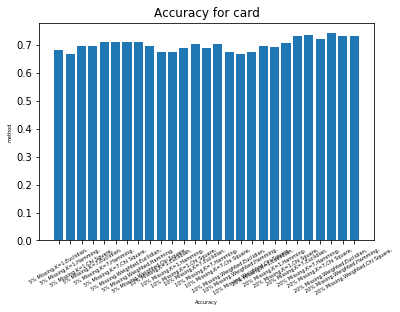

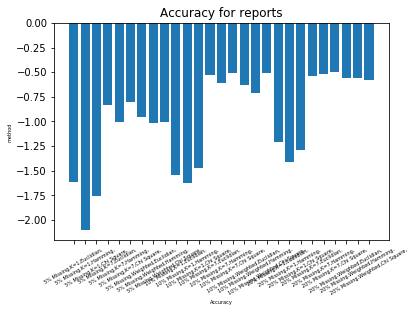

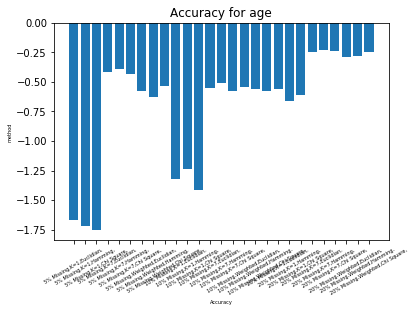

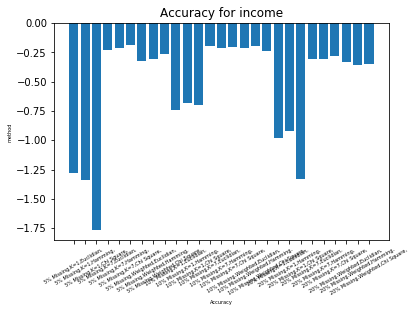

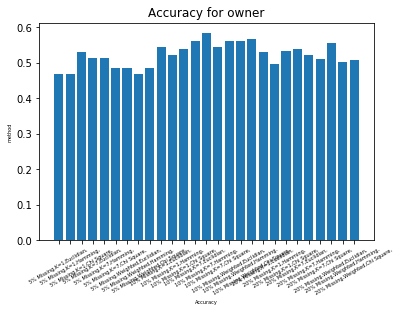

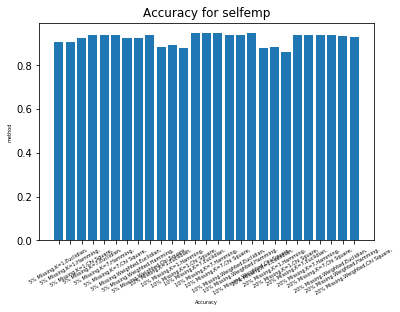

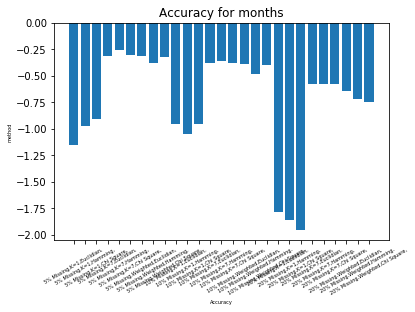

In [11]:
#plotting accurracy for each column with different combinations
for col_n in col_name_list:    
    plot_bar_x(ansers_all[col_n],y_Ax,col_n)